Dataset Link: https://www.kaggle.com/shayanfazeli/heartbeat

Kaggle Notebook Used for Ref: https://www.kaggle.com/gregoiredc/arrhythmia-on-ecg-classification-using-cnn



> Import Packages


---







In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm




> Read the Data

---





In [ ]:
train_df=pd.read_csv('/content/drive/My Drive/Smart Health/ECG_Project/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/drive/My Drive/Smart Health/ECG_Project/mitbih_test.csv',header=None)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(87554, 188)
(21892, 188)


Convert the targte value from float to int

In [ ]:
# Since the targte is categorical it needs to be converted to int
train_df[187]=train_df[187].astype(int)
# Target label count
df_plot=train_df[187].value_counts()

Plot Target Label Count

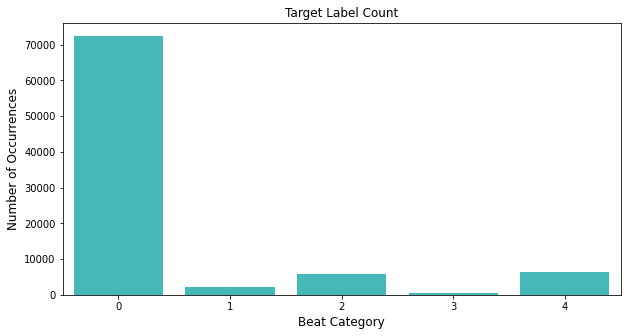

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(df_plot.index, df_plot.values, alpha=0.8,color='c')
plt.title('Target Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Beat Category', fontsize=12)
plt.show()

Perform OverSampling on Training Dataset to Balance the dataset

In [ ]:
from sklearn.utils import resample
target_0=train_df[train_df[187]==0]
target_1=train_df[train_df[187]==1]
target_2=train_df[train_df[187]==2]
target_3=train_df[train_df[187]==3]
target_4=train_df[train_df[187]==4]

#Each target has 20000 entires 
#For target with lower count it duplicates the entries
target_0_sample=resample(target_0,replace=True,n_samples=20000,random_state=123)
target_1_sample=resample(target_1,replace=True,n_samples=20000,random_state=123)
target_2_sample=resample(target_2,replace=True,n_samples=20000,random_state=123)
target_3_sample=resample(target_3,replace=True,n_samples=20000,random_state=123)
target_4_sample=resample(target_4,replace=True,n_samples=20000,random_state=123)

train_upsampled=pd.concat([target_0_sample,target_1_sample,target_2_sample,target_3_sample,target_4_sample])

In [ ]:
train_upsampled[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
15725,1.0,0.856522,0.365217,0.130435,0.121739,0.130435,0.082609,0.073913,0.060870,0.060870,0.056522,0.065217,0.047826,0.060870,0.047826,0.073913,0.060870,0.078261,0.069565,0.091304,0.086957,0.113043,0.095652,0.130435,0.126087,0.160870,0.173913,0.230435,0.234783,0.282609,0.282609,0.313043,0.260870,0.247826,0.247826,0.282609,0.260870,0.247826,0.213043,0.186957,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
28030,1.0,0.732704,0.238994,0.069182,0.128931,0.097484,0.069182,0.047170,0.047170,0.025157,0.037736,0.018868,0.018868,0.012579,0.012579,0.009434,0.003145,0.022013,0.028302,0.025157,0.037736,0.044025,0.069182,0.062893,0.081761,0.084906,0.088050,0.100629,0.113208,0.106918,0.113208,0.128931,0.135220,0.138365,0.147799,0.128931,0.122642,0.103774,0.106918,0.081761,...,0.034591,0.009434,0.018868,0.0,0.015723,0.012579,0.012579,0.006289,0.015723,0.009434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17730,1.0,0.959799,0.733668,0.467337,0.221106,0.080402,0.065327,0.090452,0.090452,0.075377,0.105528,0.120603,0.105528,0.110553,0.130653,0.130653,0.135678,0.135678,0.150754,0.180905,0.160804,0.150754,0.185930,0.201005,0.190955,0.180905,0.201005,0.231156,0.226131,0.216080,0.241206,0.256281,0.241206,0.216080,0.221106,0.216080,0.175879,0.135678,0.120603,0.125628,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
61404,1.0,0.946009,0.565728,0.201878,0.234742,0.260563,0.260563,0.237089,0.244131,0.237089,0.248826,0.241784,0.244131,0.227700,0.239437,0.234742,0.244131,0.227700,0.241784,0.237089,0.244131,0.244131,0.253521,0.253521,0.279343,0.281690,0.291080,0.305164,0.307512,0.316901,0.330986,0.330986,0.356808,0.352113,0.356808,0.356808,0.352113,0.345070,0.335681,0.302817,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
63206,0.0,0.153125,0.293750,0.375000,0.412500,0.406250,0.425000,0.431250,0.412500,0.431250,0.443750,0.450000,0.431250,0.450000,0.478125,0.484375,0.475000,0.481250,0.500000,0.506250,0.506250,0.540625,0.575000,0.575000,0.587500,0.621875,0.671875,0.693750,0.700000,0.743750,0.765625,0.750000,0.784375,0.812500,0.800000,0.762500,0.721875,0.665625,0.606250,0.571875,...,0.543750,0.581250,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Reshuffle the data

In [ ]:
#After resample the data is grouped by target label and needs to be shuffles
train_upsampled=train_upsampled.sample(frac=1)
train_upsampled=train_upsampled.sample(frac=1)

In [ ]:
train_upsampled[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
82624,1.000000,0.774468,0.710638,0.672340,0.621277,0.582979,0.540426,0.485106,0.421277,0.259574,0.148936,0.051064,0.034043,0.034043,0.055319,0.114894,0.225532,0.323404,0.412766,0.446809,0.468085,0.485106,0.531915,0.510638,0.527660,0.531915,0.557447,0.587234,0.600000,0.600000,0.629787,0.634043,0.646809,0.659574,0.676596,0.672340,0.685106,0.689362,0.706383,0.719149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
81010,1.000000,0.905119,0.687890,0.399501,0.158552,0.121099,0.127341,0.099875,0.084894,0.074906,0.059925,0.053683,0.049938,0.032459,0.024969,0.018727,0.014981,0.009988,0.000000,0.008739,0.016230,0.016230,0.042447,0.063670,0.088639,0.116105,0.131086,0.163546,0.199750,0.222222,0.238452,0.264669,0.275905,0.288390,0.284644,0.280899,0.288390,0.275905,0.252185,0.240949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
39883,0.850348,0.641531,0.388631,0.139211,0.049884,0.121810,0.132251,0.104408,0.102088,0.102088,0.099768,0.098608,0.091647,0.092807,0.098608,0.097448,0.103248,0.110209,0.119490,0.129930,0.139211,0.160093,0.186775,0.212297,0.233179,0.262181,0.281903,0.312065,0.331787,0.350348,0.368910,0.368910,0.365429,0.367749,0.363109,0.349188,0.336427,0.319026,0.310905,0.293503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
74100,0.842553,0.774468,0.217021,0.000000,0.046809,0.093617,0.102128,0.136170,0.208511,0.178723,0.174468,0.217021,0.280851,0.302128,0.314894,0.331915,0.319149,0.293617,0.323404,0.340426,0.327660,0.323404,0.344681,0.344681,0.323404,0.327660,0.365957,0.387234,0.395745,0.417021,0.451064,0.472340,0.463830,0.468085,0.502128,0.527660,0.519149,0.523404,0.519149,0.506383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
13410,1.000000,0.649635,0.141119,0.175182,0.128954,0.087591,0.092457,0.087591,0.085158,0.133820,0.218978,0.289538,0.313869,0.330900,0.330900,0.357664,0.367397,0.374696,0.379562,0.391728,0.403893,0.416058,0.435523,0.459854,0.472019,0.501217,0.518248,0.537713,0.554745,0.547445,0.508516,0.472019,0.435523,0.391728,0.357664,0.326034,0.291971,0.277372,0.265207,0.243309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Plot Target Label Count after resampling

In [ ]:
df_upsampled=train_upsampled[187].value_counts()

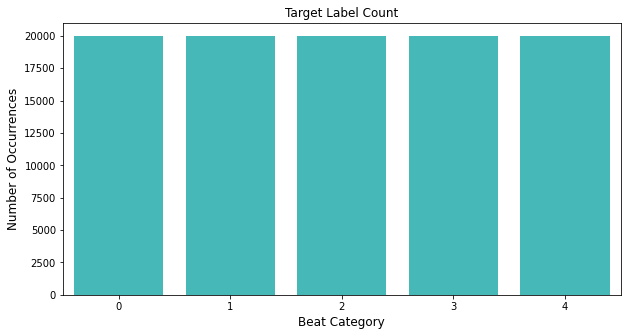

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(df_upsampled.index, df_upsampled.values, alpha=0.8,color='c')
plt.title('Target Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Beat Category', fontsize=12)
plt.show()

Plot the 1 heart beat for each target label

In [ ]:
c=train_upsampled.groupby(187,group_keys=False).apply(lambda train_upsampled : train_upsampled.sample(1))

In [ ]:
c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
50019,0.946809,0.847518,0.578014,0.223404,0.109929,0.042553,0.049645,0.010638,0.024823,0.028369,0.042553,0.024823,0.039007,0.024823,0.039007,0.021277,0.035461,0.007092,0.014184,0.003546,0.000000,0.000000,0.010638,0.003546,0.024823,0.014184,0.046099,0.039007,0.078014,0.088652,0.117021,0.131206,0.141844,0.145390,0.159574,0.145390,0.138298,0.120567,0.117021,0.109929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73698,0.796226,0.252830,0.000000,0.090566,0.098113,0.071698,0.083019,0.094340,0.105660,0.098113,0.113208,0.132075,0.060377,0.071698,0.094340,0.098113,0.124528,0.158491,0.086792,0.071698,0.116981,0.132075,0.120755,0.116981,0.113208,0.101887,0.086792,0.098113,0.079245,0.030189,0.037736,0.045283,0.045283,0.037736,0.033962,0.045283,0.045283,0.067925,0.052830,0.052830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
76684,0.932331,0.909774,0.832080,0.686717,0.538847,0.481203,0.443609,0.426065,0.483709,0.428571,0.233083,0.167920,0.140351,0.115288,0.090226,0.075188,0.062657,0.052632,0.030075,0.030075,0.027569,0.007519,0.010025,0.000000,0.000000,0.005013,0.007519,0.012531,0.022556,0.042607,0.052632,0.085213,0.115288,0.142857,0.167920,0.197995,0.223058,0.248120,0.253133,0.260652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80688,0.964539,1.000000,0.629433,0.343972,0.198582,0.154255,0.122340,0.118794,0.097518,0.102837,0.086879,0.086879,0.078014,0.081560,0.072695,0.069149,0.049645,0.062057,0.046099,0.047872,0.039007,0.040780,0.039007,0.056738,0.056738,0.086879,0.078014,0.109929,0.127660,0.157801,0.163121,0.182624,0.170213,0.182624,0.170213,0.175532,0.166667,0.168440,0.159574,0.177305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
86837,0.715517,0.502874,0.477012,0.439655,0.402299,0.353448,0.324713,0.252874,0.206897,0.086207,0.045977,0.000000,0.017241,0.034483,0.068966,0.106322,0.198276,0.252874,0.324713,0.353448,0.385057,0.390805,0.408046,0.396552,0.410920,0.410920,0.436782,0.436782,0.456897,0.448276,0.477012,0.485632,0.502874,0.491379,0.522988,0.531609,0.545977,0.540230,0.528736,0.522988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


Text(0.5, 1.0, 'Q')

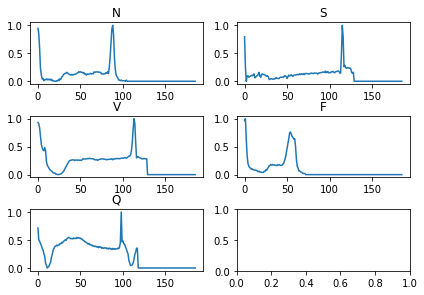

In [ ]:
fig, axs = plt.subplots(3,2)
axs[0][0].plot(c.iloc[0,:186])
axs[0][1].plot(c.iloc[1,:186])
axs[1][0].plot(c.iloc[2,:186])
axs[1][1].plot(c.iloc[3,:186])
axs[2][0].plot(c.iloc[4,:186])
#plt.subplots_adjust(bottom=0.05, right=0.8, top=0.9)
plt.tight_layout()
axs[0][0].set_title('N')
axs[0][1].set_title('S')
axs[1][0].set_title('V')
axs[1][1].set_title('F')
axs[2][0].set_title('Q')


Reshape X_train and X_test to 3D since Conv1D requires 3D data

In [ ]:
X_train=train_upsampled.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(100000, 186, 1)
(21892, 186, 1)


Convert the Target label to categorical

In [ ]:
target_train=train_upsampled[187]
target_test=test_df[187]
Y_train=to_categorical(target_train)
Y_test=to_categorical(target_test)

In [ ]:
print(Y_train.shape)
print(Y_test.shape)

(100000, 5)
(21892, 5)


Performance Evaluation Function

In [ ]:
def showResults(test, pred):
    #target_names = ['positive', 'negative']
    # print(classification_report(test, pred, target_names=target_names))
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    #loss=log_loss(test,pred)
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    #print("Loss : {}".format(loss))
    cm=confusion_matrix(test, pred)
    print(cm)

Model Defination

In [ ]:
verbose, epoch, batch_size = 1, 100, 32
activationFunction='relu'

def getModel():
    
    cnnmodel = Sequential()
    #cnnmodel.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
    #cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(64, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(5, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 185, 128)          384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 92, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 64)            16448     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 45, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 44, 32)            4128      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 22, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 21, 16)            1

Model can be trained in  two ways


*   Traditional Training
*   Cross Validatin Training

For model Hyper parameters optimization execute the Grid Search Section





> Traditional Training

---





In [ ]:
modelhistory= cnnmodel.fit(X_train, Y_train, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Epoch 1/100
2500/2500 [==============================] - 57s 23ms/step - loss: 0.5221 - accuracy: 0.8080 - val_loss: 0.2803 - val_accuracy: 0.8907
Epoch 2/100
2500/2500 [==============================] - 57s 23ms/step - loss: 0.2971 - accuracy: 0.8900 - val_loss: 0.2355 - val_accuracy: 0.9144
Epoch 3/100
2500/2500 [==============================] - 57s 23ms/step - loss: 0.2409 - accuracy: 0.9104 - val_loss: 0.1632 - val_accuracy: 0.9423
Epoch 4/100
2500/2500 [==============================] - 59s 24ms/step - loss: 0.2052 - accuracy: 0.9229 - val_loss: 0.1520 - val_accuracy: 0.9452
Epoch 5/100
2500/2500 [==============================] - 60s 24ms/step - loss: 0.1833 - accuracy: 0.9317 - val_loss: 0.1164 - val_accuracy: 0.9575
Epoch 6/100
2500/2500 [==============================] - 60s 24ms/step - loss: 0.1669 - accuracy: 0.9391 - val_loss: 0.1065 - val_accuracy: 0.9617
Epoch 7/100
2500/2500 [==============================] - 61s 24ms/step - loss: 0.1570 - accuracy: 0.9418 - val_loss: 0

Plot the Training Accuracy and Loss

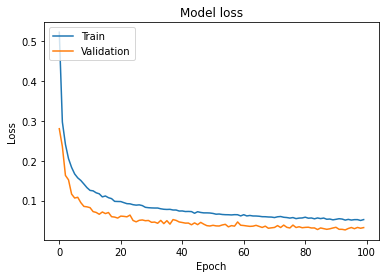

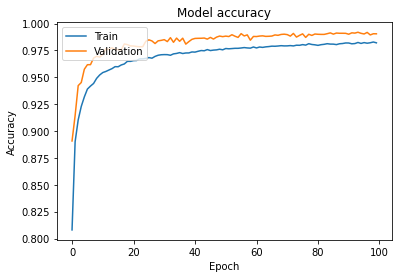

In [ ]:
# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/My Drive/Smart Health/ECG_Project/Loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/My Drive/Smart Health/ECG_Project/Accuracy.png', format='png', dpi=1200)
plt.show()

Test the Model

In [ ]:
cnnpredictions = cnnmodel.predict(X_test, verbose=1)

685/685 [==============================] - 4s 6ms/step


Evaluate the Performance

In [ ]:
cnn_predict=np.argmax(cnnpredictions,axis=1)
cnn_actual_value=np.argmax(Y_test,axis=1)
showResults(cnn_actual_value, cnn_predict)

Accuracy  : 0.9572446555819477
Precision : 0.9679249827715931
f1Score : 0.9609284897102034
[[17388   346   169   148    67]
 [   63   472    16     4     1]
 [   19    13  1372    38     6]
 [   10     1    10   141     0]
 [   16     3     4     2  1583]]


In [ ]:
#========== Save the trained mode for future use ==========
cnnmodel.save("/content/drive/My Drive/Smart Health/ECG_Project/ECGModel.h5")




> Cross Validation Training

---




**Note: Re-run the Model Defination**

In [ ]:
tempX=train_upsampled.iloc[:,:186].values
tempY=train_upsampled[187].values
skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X_train, target_train)
foldNum=0
for train_index, val_index in skf.split(X_train, target_train):
    foldNum+=1
    print("Results for fold",foldNum)
    X_traincv, X_valcv = tempX[train_index], tempX[val_index]
    Y_traincv, Y_valcv = tempY[train_index], tempY[val_index]

    X_traincv=X_traincv.reshape(X_traincv.shape[0],X_traincv.shape[1],1)
    X_valcv=X_valcv.reshape(X_valcv.shape[0],X_valcv.shape[1],1)
    # one hot encode
    Y_traincv = to_categorical(Y_traincv)
    Y_valcv = to_categorical(Y_valcv)
    
    history = cnnmodel.fit(X_traincv, Y_traincv, validation_data = (X_valcv, Y_valcv), epochs=epoch, batch_size=batch_size)  
    yPredict = cnnmodel.predict(X_valcv)

    #Converting one hot encoded test label to label    
    pred = np.argmax(yPredict, axis=1)
    val = np.argmax(Y_valcv, axis=1)
    
    showResults(val, pred)

Test the Model

In [ ]:
cnnpredictionscv = cnnmodel.predict(X_test, verbose=1)

Evaluate the Performance

In [ ]:
cnn_predictcv=np.argmax(cnnpredictionscv,axis=1)
cnn_actual_valuecv=np.argmax(Y_test,axis=1)
showResults(cnn_actual_valuecv, cnn_predictcv)



> Grid Search 

---
**Note: Update the Model Defination below to the model defination for which you want to find the optimal hyperparameter**





In [ ]:
def gridModel(optimizer='adam'):

    cnnmodel1 = Sequential()
    
    cnnmodel1 = Sequential()
    #cnnmodel1.add(Conv1D(filters=256, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    #cnnmodel1.add(MaxPooling1D(pool_size=2))
    cnnmodel1.add(Conv1D(filters=128, kernel_size=2, activation='relu'),input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel1.add(MaxPooling1D(pool_size=2))
    cnnmodel1.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    cnnmodel1.add(MaxPooling1D(pool_size=2))
    cnnmodel1.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    cnnmodel1.add(MaxPooling1D(pool_size=2))
    cnnmodel1.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
    cnnmodel1.add(MaxPooling1D(pool_size=2))
    cnnmodel1.add(Dropout(rate=0.2))
    cnnmodel1.add(Flatten())
    cnnmodel1.add(Dense(64, activation='relu'))
    cnnmodel1.add(Dense(32, activation='relu'))
    cnnmodel1.add(Dense(5, activation='softmax'))
    cnnmodel1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel1.summary()
    return cnnmodel1


cnnmodel1 = getModel()

In [ ]:
# Select the hyper-parameter values
model_init_batch_epoch_CV = KerasClassifier(build_fn=gridModel, verbose=1)
batches = [32,64]
#optimizer = ['Adam','RMSprop']
epoch=[20,50]

param_grid = dict(batch_size=batches, 
                  epochs=epoch)
grid_cnn_results= GridSearchCV(estimator=model_init_batch_epoch_CV, param_grid=param_grid, cv=3,return_train_score=True)
#fit model to data
grid_cnn_results.fit(X_train, Y_train)
print("Best Parameters are")
print(grid_cnn_results.best_params_)
print("Best Score is")
print(grid_cnn_results.best_score_)